In [13]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from tqdm.auto import tqdm
from torchinfo import summary
from torchvision import models
from tqdm.notebook import tqdm
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
data_transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])

train_set = datasets.VOCSegmentation(root="./data",
                                      year="2012",
                                      image_set="train",
                                      transform=data_transform,
                                      target_transform=data_transform)

val_set = datasets.VOCSegmentation(root="./data",
                                     year="2012",
                                     image_set="trainval",
                                     transform=data_transform,
                                     target_transform=data_transform)

test_set = datasets.VOCSegmentation(root="./data", year="2012", image_set="val")

In [15]:
train_loader = DataLoader(train_set, batch_size=3, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=3, shuffle=True, drop_last=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=3, shuffle=True, drop_last=True)

In [16]:
class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        auxiliary_x = self.resnet.layer1(x)
        x = self.resnet.layer2(auxiliary_x)

        return x, auxiliary_x

In [17]:
class PyramidPoolingModule(nn.Module):

    def __init__(self, pools, in_channels, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.pooling_layers = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=p), # Pool
                nn.Conv2d(in_channels, int(in_channels / len(pools)), 1, 1, 0, 1, bias=False),
                nn.Dropout2d()
            )
            for p in pools
        ])

    def forward(self, x):
        outputs = [x]
        for pooling_layer in self.pooling_layers:
            layer_output = pooling_layer(x)
            outputs.append(F.interpolate(layer_output, size=self.input_shape, mode="bilinear", align_corners=True))

        return torch.cat(outputs, dim=1)

In [18]:
class SegmentationClassifier(nn.Module):

    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.segmentation = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Dropout2d(),
            nn.UpsamplingBilinear2d(scale_factor=scale_factor)
        )

    def forward(self, x):
        return self.segmentation(x)

In [19]:
class PSPNet(nn.Module):
    def __init__(self, input_shape, n_classes):
        super().__init__()
        self.feature_extractor = CustomResNet()
        self.pyramid_pooling = PyramidPoolingModule(input_shape=(int(input_shape[0] / 8), int(input_shape[1] / 8)), in_channels=512, pools = (6, 3, 2, 1))
        self.classifier = SegmentationClassifier(in_channels=1024, out_channels=n_classes, scale_factor=8)
        self.aux_classifier = SegmentationClassifier(in_channels=256, out_channels=n_classes, scale_factor=4)

    def forward(self, x):
        encoder_outputs, encoder_auxiliary = self.feature_extractor(x)
        pyramid_outputs = self.pyramid_pooling(encoder_outputs)
        return self.classifier(pyramid_outputs), self.aux_classifier(encoder_auxiliary)

In [20]:
model = PSPNet(input_shape=(256,256), n_classes=20)
summary(model, input_size=(3, 3, 256, 256))

Layer (type:depth-idx)                             Output Shape              Param #
PSPNet                                             [3, 20, 256, 256]         --
├─CustomResNet: 1-1                                [3, 512, 32, 32]          --
│    └─ResNet: 2-1                                 --                        24,112,104
│    │    └─Conv2d: 3-1                            [3, 64, 128, 128]         9,408
│    │    └─BatchNorm2d: 3-2                       [3, 64, 128, 128]         128
│    │    └─ReLU: 3-3                              [3, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                         [3, 64, 64, 64]           --
│    │    └─Sequential: 3-5                        [3, 256, 64, 64]          215,808
│    │    └─Sequential: 3-6                        [3, 512, 32, 32]          1,219,584
├─PyramidPoolingModule: 1-2                        [3, 1024, 32, 32]         --
│    └─ModuleList: 2-2                             --                        --
│    │    └

In [21]:
class DeepSupervisionLoss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, output, target):
        loss = self.cross_entropy(output[0], target)
        aux_loss = self.cross_entropy(output[1], target)
        return loss + self.alpha * aux_loss

In [101]:
criterion = DeepSupervisionLoss(alpha=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [23]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    model.to(device)
    train_loss = []
    val_loss = []
    for e in tqdm(range(epochs)):
        model.train()
        epoch_train_loss = []
        for i, (img, mask) in enumerate(train_loader):
            img = img.to(device)
            mask = mask
            mask = mask.to(device)
            output = model(img)
            loss = criterion(output, mask.squeeze().long())
            epoch_train_loss.append(loss.cpu().detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        epoch_val_loss = []
        with torch.inference_mode():
            for i, (img, mask) in enumerate(val_loader):
                img = img.to(device)
                mask = mask
                mask = mask.to(device)
                output = model(img)
                loss = criterion(output, mask.squeeze().long())
                epoch_val_loss.append(loss.cpu().detach().numpy())

        train_loss.append(np.mean(epoch_train_loss))
        val_loss.append(np.mean(epoch_val_loss))

        print(f"Epoch {e} | Loss: {np.mean(epoch_train_loss)} | Val Loss: {np.mean(epoch_val_loss)}")

    return train_loss, val_loss

In [91]:
train_loss, val_loss = fit(100, model, train_loader, val_loader, criterion, optimizer)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Loss: 1.8088263273239136 | Val Loss: 0.27215775847435
Epoch 1 | Loss: 1.7759352922439575 | Val Loss: 0.272005558013916
Epoch 2 | Loss: 1.8474317789077759 | Val Loss: 0.2693878710269928
Epoch 3 | Loss: 1.805307388305664 | Val Loss: 0.26524972915649414
Epoch 4 | Loss: 1.8503321409225464 | Val Loss: 0.2611912488937378
Epoch 5 | Loss: 1.8330585956573486 | Val Loss: 0.26704633235931396
Epoch 6 | Loss: 1.7607624530792236 | Val Loss: 0.25976553559303284
Epoch 7 | Loss: 1.7764885425567627 | Val Loss: 0.2618850767612457
Epoch 8 | Loss: 1.7814624309539795 | Val Loss: 0.26053744554519653
Epoch 9 | Loss: 1.8209296464920044 | Val Loss: 0.2591933012008667
Epoch 10 | Loss: 1.7617987394332886 | Val Loss: 0.26053386926651
Epoch 11 | Loss: 1.854812741279602 | Val Loss: 0.26223525404930115
Epoch 12 | Loss: 1.8066773414611816 | Val Loss: 0.25701040029525757
Epoch 13 | Loss: 1.7537161111831665 | Val Loss: 0.26007166504859924
Epoch 14 | Loss: 1.7854403257369995 | Val Loss: 0.2612936496734619
Epoch

KeyboardInterrupt: 

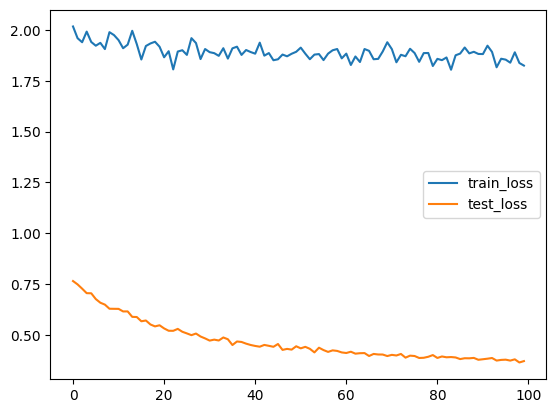

In [65]:
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="test_loss")
plt.legend()

In [100]:
torch.save(model.state_dict(), "./models/01_pspnet_pascalvoc_2.pth")

In [27]:
def predict_image_mask(model, image):
    model.eval()
    model.to(device)
    image = image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        output, _ = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

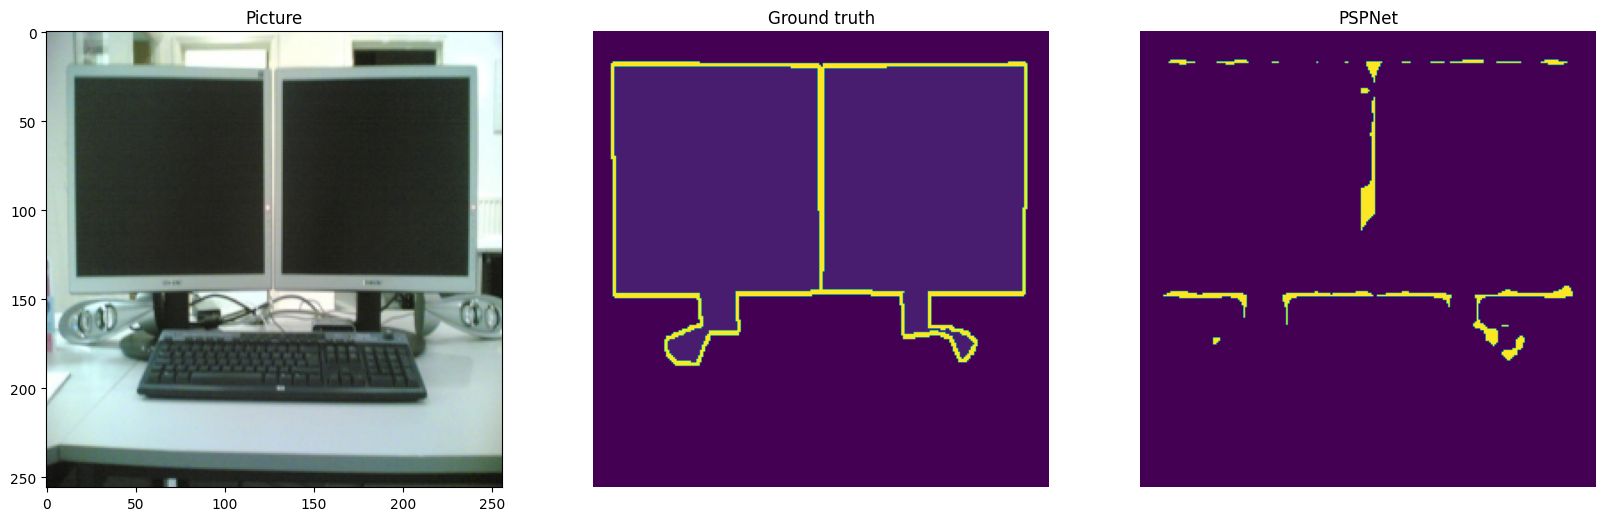

In [99]:
image, mask = val_set[7]
pred_mask = predict_image_mask(model, image)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(T.ToPILImage()(image))
ax1.set_title('Picture')

ax2.imshow(mask.squeeze())
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('PSPNet')
ax3.set_axis_off()